In [1]:
import pandas as pd
import numpy as np
from sklearn.svm import SVC
import shap
import pickle

from sklearn.pipeline import make_pipeline, Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.feature_selection import VarianceThreshold
from sklearn.model_selection import train_test_split, cross_val_score, StratifiedKFold
import warnings

warnings.simplefilter(action="ignore", category=FutureWarning)

c:\Users\UST\Desktop\Juswa\telomere_health_geography\venv\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


<h1 style="text-align:center">Dataset Loading</h1>

In [2]:
def read_data():
    df = pd.read_csv("./input/telomere_geography_health_3_18.csv")
    return df

def categorical_to_numeric(df, column, mapping, regex=False):
    df[column] = df[column].replace(mapping, regex=regex)

def fill_na(df, column, default):
    fill_value = np.nan
    if default == "median":
        fill_value = df[column].median()
    elif default == "mode":
        fill_value = df[column].mode()[0]

    df[column] = df[column].fillna(fill_value)

<h1 style="text-align:center">Data Preprocessing</h1>

In [3]:
def preprocess_data(df):

    categorical_to_numeric(
        df,
        "cigarette_smoking",
        {
            "No information": np.nan,
            "Former Smoker": np.nan,
            "Never Smoker": 0,
            "Occasional Smoker": 1,
            "Regular Smoker": 2,
        },
    )

    categorical_to_numeric(
        df,
        "physical_activity_cohort",
        {
            "No information": np.nan,
            "Sedentary (Inactive)": 0,
            "Minimally Active": 1,
            "Lightly Active": 2,
            "Moderately Active": 3,
            "Highly Active": 4,
        },
    )

    categorical_to_numeric(
        df,
        "alcohol_drinking",
        {
            "No information": np.nan,
            "Former Drinker": np.nan,
            "Never Drinker": 0,
            "Occasional Drinker": 1,
            "Moderate Drinker": 2,
            "Heavy Drinker": 3,
        },
    )

    categorical_to_numeric(
        df,
        "bp_category",
        {
            "No information": np.nan,
            "Hypotension (Low BP)": 0,
            "Normal BP": 1,
            "Elevated BP": 2,
            "Hypertension Stage 1": 3,
            "Hypertension Stage 2": 4,
            "Hypertensive Crisis": 5,
        },
    )

    categorical_to_numeric(
        df,
        "cardiovascular_disease_diagnosis",
        {
            "^No known*": 0,
            "^Non-cardiovascular*": 0,
            "^Single.*": 1,
            "^Multi.*": 1,
        },
        regex=True,
    )

    categorical_to_numeric(
        df,
        "cancer_diagnosis",
        {
            "^Clinically Healthy*": 0,
            "^Non-oncologic*": 0,
            "^Single.*": 1,
            "^Multi.*": 1,
        },
        regex=True,
    )

    categorical_to_numeric(
        df,
        "depression_anxiety",
        {
            "^No Known*": 0,
            "^Anxiety and/or*": 1,
            "^Multi.*": 1,
        },
        regex=True,
    )

    categorical_to_numeric(
        df,
        "allergy",
        {
            "^No Diagnosed*": 0,
            "^Single.*": 1,
            "^Multi.*": 1,
        },
        regex=True,
    )

    categorical_to_numeric(
        df,
        "diabetes_diagnosis",
        {
            "^No known diagnosis*": 0,
            "^Diagnosed with*": 1,
        },
        regex=True,
    )

    df["hr"] = pd.to_numeric(df["hr"], errors="coerce")
    df["rr"] = pd.to_numeric(df["rr"], errors="coerce")

    fill_na(df, "hr", "median")
    fill_na(df, "rr", "median")
    fill_na(df, "bmi", "median")
    fill_na(df, "alcohol_drinking", "mode")
    fill_na(df, "cigarette_smoking", "mode")
    fill_na(df, "bp_category", "mode")
    fill_na(df, "physical_activity_cohort", "mode")

    df = pd.get_dummies(df, columns=["sex", "rural_or_urban"])
    return df

<h1 style="text-align:center">Model Training</h1>

In [ ]:
def train_model(df, to_predict):
    y = df.pop(to_predict)
    X = df

    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42)

    # Feature Selection
    selector = VarianceThreshold(threshold=0.1)

    X_train_selected = selector.fit_transform(X_train)
    X_test_selected = selector.transform(X_test)

    # Scaling and Training Pipeline
    pipeline = Pipeline(
        [("scaler", StandardScaler()), ("lsvc", SVC(kernel="linear", probability=True))]
    )

    #Training Model
    pipeline.fit(X_train_selected, y_train)

    # Compute Cross-Validation Accuracy
    cv_scores = cross_val_score(pipeline, X_train_selected, y_test, cv=5, scoring="accuracy")
    cv_accuracy = np.mean(cv_scores)  # Average accuracy across folds

    # Feature Variance, Weights, and Shapley
    scaler = pipeline.named_steps["scaler"]
    selected_weights = np.array(pipeline.named_steps["lsvc"].coef_[0])
    selected_features = X_train.columns[selector.get_support()]
    selected_variances = selector.variances_[selector.get_support()]

    explainer = shap.LinearExplainer(
        pipeline.named_steps["lsvc"], scaler.transform(X_train_selected)
    )
    shap_values = explainer.shap_values(scaler.transform(X_test_selected))

    feature_vw = pd.DataFrame(
        data={
            "Selected Features": selected_features,
            "Variances": selected_variances,
            "Weights": selected_weights,
        }
    )

    # Prediction Accuracy
    score = pipeline.score(X_test_selected, y_test)
    probabilties = np.array(pipeline.predict_proba(X_test_selected)[:, 1])
    y_prediction = pipeline.predict(X_test_selected)

    prediction_df = pd.DataFrame(
        data={
            "Actual": y_test.reset_index(drop=True).map({1: "Present", 0: "Absent"}),
            "Predicted": pd.Series(y_prediction)
            .reset_index(drop=True)
            .map({1: "Present", 0: "Absent"}),
            "Probability (%)": np.round(probabilties * 100, decimals=2),
            "Match": pd.Series((y_prediction == y_test).astype(bool))
            .reset_index(drop=True)
            .map({True: "Correct", False: "Incorrect"}),
        }
    )

    prediction_df["Accuracy"] = pd.Series(round(score * 100, 2))

    return (pipeline, feature_vw, shap_values, prediction_df.fillna(""), cv_accuracy)


<h1 style="text-align:center">Model Assessment</h1>

In [5]:
model_accuracy = pd.DataFrame(columns=['Prediction Model', "5-Fold Accuracy"])

<h2 style="text-align:center">Cardiovascular Disease Prediction</h1>

In [6]:
cvd_df = read_data()
cvd_df_preprocessed = preprocess_data(cvd_df)

cvd_pipeline, cvd_feature_vw, cvd_shap_values, cvd_prediction_df, cvd_cv_accuracy = train_model(
    cvd_df_preprocessed, to_predict="cardiovascular_disease_diagnosis"
)

cvd_feature_vw.to_csv("./output/feature_variances_weights/cvd_feature_vw.csv",index=False)

cvd_shapley_df = pd.DataFrame(cvd_shap_values, columns=cvd_feature_vw['Selected Features'])
cvd_shapley_df.to_csv("output/feature_shapley/cvd_shapley.csv", index=False)

model_accuracy.loc[0] = ['CVD', cvd_cv_accuracy]

In [7]:
cvd_feature_vw

,Selected Features,Variances,Weights
0,telomere_length,53.518382,-0.272272
1,age,353.539013,1.334854
2,cigarette_smoking,0.382854,-0.150076
3,alcohol_drinking,0.606635,0.048511
4,physical_activity_cohort,1.605247,-0.434518
5,bmi,532.335297,0.001499
6,bp_category,1.361823,0.681141
7,hr,145.930017,0.050657
8,rr,4.318569,0.320537
9,sex_Female,0.249657,0.097186


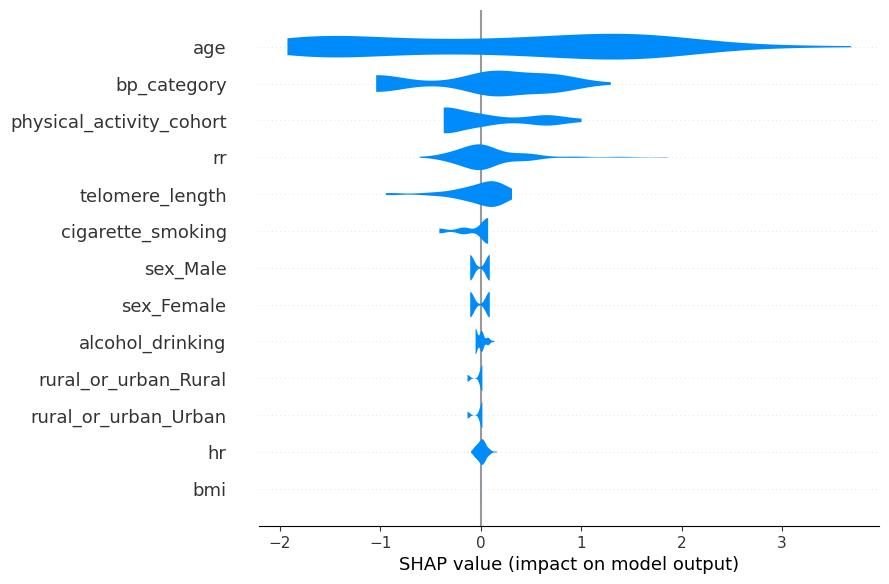

In [8]:
shap.plots.violin(cvd_shap_values, feature_names=cvd_feature_vw["Selected Features"])

In [9]:
def match_highlight(value):
    color = "green" if value == "Correct" else "red" if value == "Incorrect" else None
    return f"background-color: {color}; color: white"


cvd_prediction_df = cvd_prediction_df.applymap(
    lambda x: ("%.10g" % x) if isinstance(x, (int, float)) else x
)
styled_cvd_prediction_df = cvd_prediction_df.head(10).style.applymap(match_highlight)

display(styled_cvd_prediction_df)

,Actual,Predicted,Probability (%),Match,Accuracy
0,Absent,Present,66.27,Incorrect,79.49
1,Absent,Absent,38.01,Correct,
2,Absent,Absent,31.22,Correct,
3,Present,Absent,23.01,Incorrect,
4,Absent,Present,71.48,Incorrect,
5,Absent,Absent,5.19,Correct,
6,Absent,Absent,1.86,Correct,
7,Absent,Absent,37.88,Correct,
8,Absent,Present,59.53,Incorrect,
9,Absent,Absent,13.44,Correct,


<h2 style="text-align:center">Cancer Prediction</h1>

In [10]:
cancer_df = read_data()
cancer_df_preprocessed = preprocess_data(cancer_df)

cancer_pipeline, cancer_feature_vw, cancer_shap_values, cancer_prediction_df, cancer_cv_accuracy = train_model(
    cancer_df_preprocessed, to_predict="cancer_diagnosis"
)

cancer_feature_vw.to_csv("./output/feature_variances_weights/cancer_feature_vw.csv", index=False)
cancer_shapley_df = pd.DataFrame(cancer_shap_values, columns=cancer_feature_vw['Selected Features'])
cancer_shapley_df.to_csv("output/feature_shapley/cancer_shapley.csv", index=False)

model_accuracy.loc[1] = ['Cancer', cancer_cv_accuracy]

c:\Users\UST\Desktop\Juswa\telomere_health_geography\venv\Lib\site-packages\sklearn\model_selection\_split.py:776: UserWarning: The least populated class in y has only 3 members, which is less than n_splits=5.
  warnings.warn(


In [11]:
cancer_feature_vw

,Selected Features,Variances,Weights
0,telomere_length,53.518382,-0.000024
1,age,353.539013,0.000078
2,cigarette_smoking,0.382854,0.000064
3,alcohol_drinking,0.606635,-0.000185
4,physical_activity_cohort,1.605247,-0.000133
5,bmi,532.335297,-0.000010
6,bp_category,1.361823,-0.000043
7,hr,145.930017,0.000019
8,rr,4.318569,0.000024
9,cardiovascular_disease_diagnosis,0.202498,-0.000160


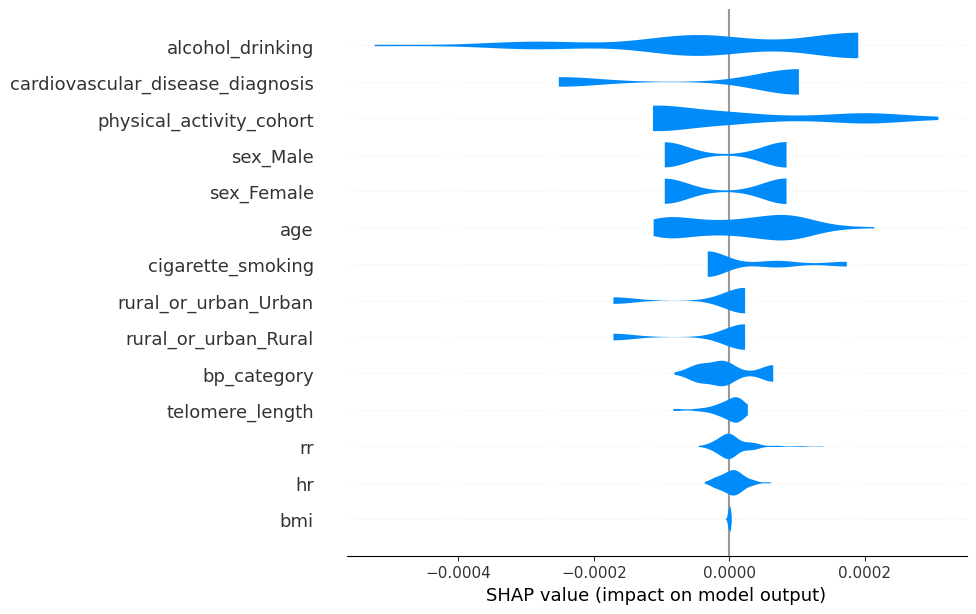

In [12]:
shap.plots.violin(cancer_shap_values, feature_names=cancer_feature_vw["Selected Features"])

In [13]:
cancer_prediction_df = cancer_prediction_df.applymap(
    lambda x: ("%.10g" % x) if isinstance(x, (int, float)) else x
)
styled_cancer_prediction_df = cancer_prediction_df.head(10).style.applymap(
    match_highlight
)

display(styled_cancer_prediction_df)

,Actual,Predicted,Probability (%),Match,Accuracy
0,Absent,Absent,0.67,Correct,100
1,Absent,Absent,0.67,Correct,
2,Absent,Absent,0.67,Correct,
3,Absent,Absent,0.67,Correct,
4,Absent,Absent,0.67,Correct,
5,Absent,Absent,0.67,Correct,
6,Absent,Absent,0.67,Correct,
7,Absent,Absent,0.67,Correct,
8,Absent,Absent,0.67,Correct,
9,Absent,Absent,0.67,Correct,


<h2 style="text-align:center">Diabetes Mellitus Prediction</h1>

In [14]:
diabetes_df = read_data()
diabetes_df_preprocessed = preprocess_data(diabetes_df)

diabetes_pipeline, diabetes_feature_vw, diabetes_shap_values, diabetes_prediction_df, diabetes_cv_accuracy = train_model(
    diabetes_df_preprocessed, to_predict="diabetes_diagnosis"
)

diabetes_feature_vw.to_csv("./output/feature_variances_weights/diabetes_feature_vw.csv", index=False)
diabetes_shapley_df = pd.DataFrame(diabetes_shap_values, columns=diabetes_feature_vw['Selected Features'])
diabetes_shapley_df.to_csv("output/feature_shapley/diabetes_shapley.csv", index=False)

model_accuracy.loc[3] = ['Diabetes', diabetes_cv_accuracy]

In [15]:
diabetes_feature_vw

,Selected Features,Variances,Weights
0,telomere_length,53.518382,0.001459
1,age,353.539013,0.023928
2,cigarette_smoking,0.382854,0.002880
3,alcohol_drinking,0.606635,-0.007666
4,physical_activity_cohort,1.605247,-0.001274
5,bmi,532.335297,0.110620
6,bp_category,1.361823,0.001021
7,hr,145.930017,-0.007439
8,rr,4.318569,0.000470
9,cardiovascular_disease_diagnosis,0.202498,0.000008


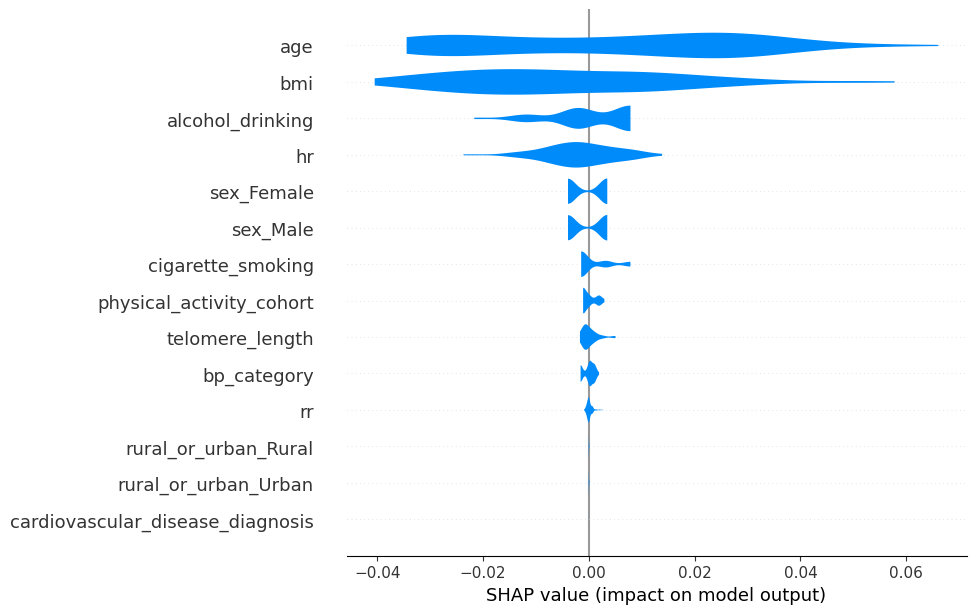

In [16]:
shap.plots.violin(diabetes_shap_values, feature_names=diabetes_feature_vw["Selected Features"])

In [17]:
diabetes_prediction_df = diabetes_prediction_df.applymap(
    lambda x: ("%.10g" % x) if isinstance(x, (int, float)) else x
)
styled_diabetes_prediction_df = diabetes_prediction_df.head(10).style.applymap(
    match_highlight
)

display(styled_diabetes_prediction_df)

,Actual,Predicted,Probability (%),Match,Accuracy
0,Present,Absent,5.89,Incorrect,95.73
1,Absent,Absent,5.44,Correct,
2,Absent,Absent,4.59,Correct,
3,Absent,Absent,5.71,Correct,
4,Absent,Absent,6.47,Correct,
5,Absent,Absent,3.51,Correct,
6,Absent,Absent,5.25,Correct,
7,Absent,Absent,7.71,Correct,
8,Absent,Absent,8.26,Correct,
9,Absent,Absent,2.17,Correct,


<h2 style="text-align:center">Depression/Anxiety Prediction</h1>

In [18]:
depression_anxiety_df = read_data()
depression_anxiety_df_preprocessed = preprocess_data(depression_anxiety_df)

(
    depression_anxiety_pipeline,
    depression_anxiety_feature_vw,
    depression_anxiety_shap_values,
    depression_anxiety_prediction_df,
    depression_anxiety_cv_accuracy,
) = train_model(
    depression_anxiety_df_preprocessed, to_predict="depression_anxiety"
)

depression_anxiety_feature_vw.to_csv("./output/feature_variances_weights/depression_anxiety_feature_vw.csv", index=False)
depression_anxiety_df = pd.DataFrame(depression_anxiety_shap_values, columns=depression_anxiety_feature_vw['Selected Features'])
depression_anxiety_df.to_csv("output/feature_shapley/depression_anxiety_shapley.csv", index=False)

model_accuracy.loc[4] = ['Depression/Anxiety', depression_anxiety_cv_accuracy]

c:\Users\UST\Desktop\Juswa\telomere_health_geography\venv\Lib\site-packages\sklearn\model_selection\_split.py:776: UserWarning: The least populated class in y has only 4 members, which is less than n_splits=5.
  warnings.warn(


In [19]:
depression_anxiety_feature_vw

,Selected Features,Variances,Weights
0,telomere_length,53.518382,-0.045297
1,age,353.539013,-0.013816
2,cigarette_smoking,0.382854,0.000000
3,alcohol_drinking,0.606635,0.125296
4,physical_activity_cohort,1.605247,-0.061600
5,bmi,532.335297,-0.007413
6,bp_category,1.361823,0.054549
7,hr,145.930017,-0.494243
8,rr,4.318569,0.280820
9,cardiovascular_disease_diagnosis,0.202498,-0.247838


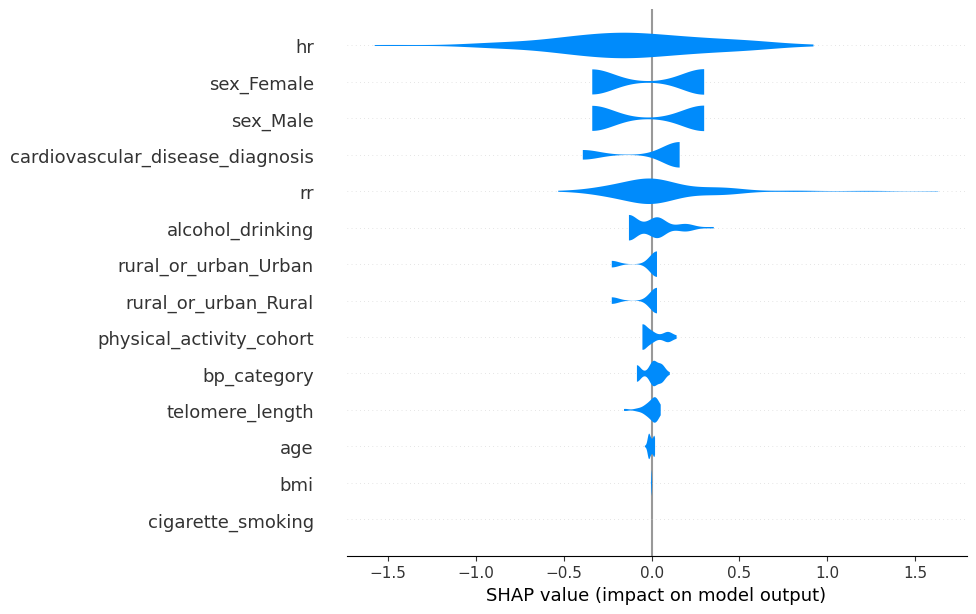

In [20]:
shap.plots.violin(depression_anxiety_shap_values, feature_names=depression_anxiety_feature_vw["Selected Features"])

In [21]:
depression_anxiety_prediction_df = depression_anxiety_prediction_df.applymap(
    lambda x: ("%.10g" % x) if isinstance(x, (int, float)) else x
)
styled_depression_anxiety_prediction_df = depression_anxiety_prediction_df.head(
    10
).style.applymap(match_highlight)

display(styled_depression_anxiety_prediction_df)

,Actual,Predicted,Probability (%),Match,Accuracy
0,Absent,Absent,0.98,Correct,98.29
1,Absent,Absent,0.88,Correct,
2,Absent,Absent,0.85,Correct,
3,Absent,Absent,0.92,Correct,
4,Absent,Absent,1.04,Correct,
5,Absent,Absent,0.98,Correct,
6,Absent,Absent,1,Correct,
7,Absent,Absent,0.98,Correct,
8,Absent,Absent,0.98,Correct,
9,Absent,Absent,0.83,Correct,


<h2 style="text-align:center">Allergy Prediction</h1>

In [22]:
allergy_df = read_data()
allergy_df_preprocessed = preprocess_data(allergy_df)

(
    allergy_pipeline,
    allergy_feature_vw,
    allergy_shap_values,
    allergy_prediction_df,
    allergy_anxiety_cv_accuracy
) = train_model(allergy_df_preprocessed, to_predict="allergy")

allergy_feature_vw.to_csv("./output/feature_variances_weights/allergy_feature_vw.csv", index=False)
allergy_shapley_df = pd.DataFrame(allergy_shap_values, columns=allergy_feature_vw['Selected Features'])
allergy_shapley_df.to_csv("output/feature_shapley/allergy_shapley.csv", index=False)

model_accuracy.loc[4] = ['Allergy', allergy_anxiety_cv_accuracy]

In [23]:
allergy_feature_vw

,Selected Features,Variances,Weights
0,telomere_length,53.518382,0.000017
1,age,353.539013,-0.000074
2,cigarette_smoking,0.382854,0.000005
3,alcohol_drinking,0.606635,-0.000030
4,physical_activity_cohort,1.605247,0.000039
5,bmi,532.335297,-0.000020
6,bp_category,1.361823,0.000039
7,hr,145.930017,-0.000004
8,rr,4.318569,0.000014
9,cardiovascular_disease_diagnosis,0.202498,0.000019


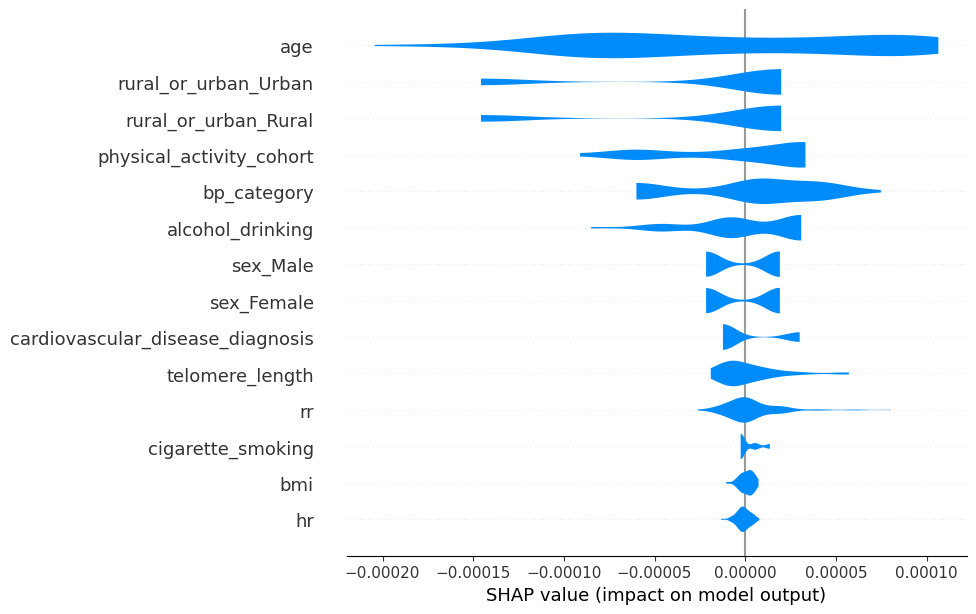

In [24]:
shap.plots.violin(allergy_shap_values, feature_names=allergy_feature_vw["Selected Features"])

In [25]:
allergy_prediction_df = allergy_prediction_df.applymap(
    lambda x: ("%.10g" % x) if isinstance(x, (int, float)) else x
)
styled_allergy_prediction_df = allergy_prediction_df.head(10).style.applymap(
    match_highlight
)

display(styled_allergy_prediction_df)

,Actual,Predicted,Probability (%),Match,Accuracy
0,Absent,Absent,10.82,Correct,86.32
1,Present,Absent,10.84,Incorrect,
2,Present,Absent,10.83,Incorrect,
3,Absent,Absent,10.9,Correct,
4,Present,Absent,10.81,Incorrect,
5,Absent,Absent,10.8,Correct,
6,Absent,Absent,10.76,Correct,
7,Absent,Absent,10.91,Correct,
8,Absent,Absent,10.79,Correct,
9,Absent,Absent,10.79,Correct,


In [26]:
model_accuracy.to_csv('./output/model_accuracy.csv', index=False)